In [1]:
import numpy as np
import cv2
import glob
import open3d as o3d
import matplotlib.pyplot as plt

from process_bag import get_images

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Loading Checkerboard Test Images

# bag_fp = "data/pose/checkerboard.bag"

# color_imgs, depth_imgs = get_images(
#     start_idx=0,
#     end_idx=1000,
#     bag_fp=bag_fp,
#     color_path=None,
#     depth_path=None,
#     align=True,
#     median=False
# )

# idxs = [0, 40, 82, 120, 160, 250, 290, 320, 360, 400, 440]
# for i in idxs:
#     print(i)
#     plt.imshow(color_imgs[i])
#     plt.show()

# color_imgs = color_imgs[idxs]
# depth_imgs = depth_imgs[idxs]
# # Save images
# np.save("data/pose/color.npy", color_imgs)
# np.save("data/pose/depth.npy", depth_imgs)

# Load images
color_imgs = np.load("data/pose/color.npy")
depth_imgs = np.load("data/pose/depth.npy")
color_imgs.shape, depth_imgs.shape

((11, 480, 640, 3), (11, 480, 640))

In [3]:
# Chessboard size
cb_counts = (8, 6)
cb_size = 0.03

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

# Define object points
objp = np.zeros((cb_counts[0]*cb_counts[1],3), np.float32)
objp[:,:2] = np.mgrid[0:cb_counts[0],0:cb_counts[1]].T.reshape(-1,2)
# Scale by checkboard square size
objp *= cb_size

In [4]:
def finetune_corners(gray, corners):
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # Arrange corner order
    if corners2[0, 0, 0] > corners2[-1, 0, 0]:
        corners2 = corners2[::-1]
    return corners2

In [5]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
used_idxs = [] # Indices of images used

for i, img in enumerate(color_imgs):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find and refine corners
    ret, corners = cv2.findChessboardCorners(gray, cb_counts, None)
    if ret == True:
        used_idxs.append(i)
        objpoints.append(objp)
        imgpoints.append(
            finetune_corners(gray, corners)
        )

In [6]:
color_imgs = color_imgs[used_idxs]
depth_imgs = depth_imgs[used_idxs]

n = len(used_idxs)
print(f"Found {n} images with checkerboard corners")

Found 11 images with checkerboard corners


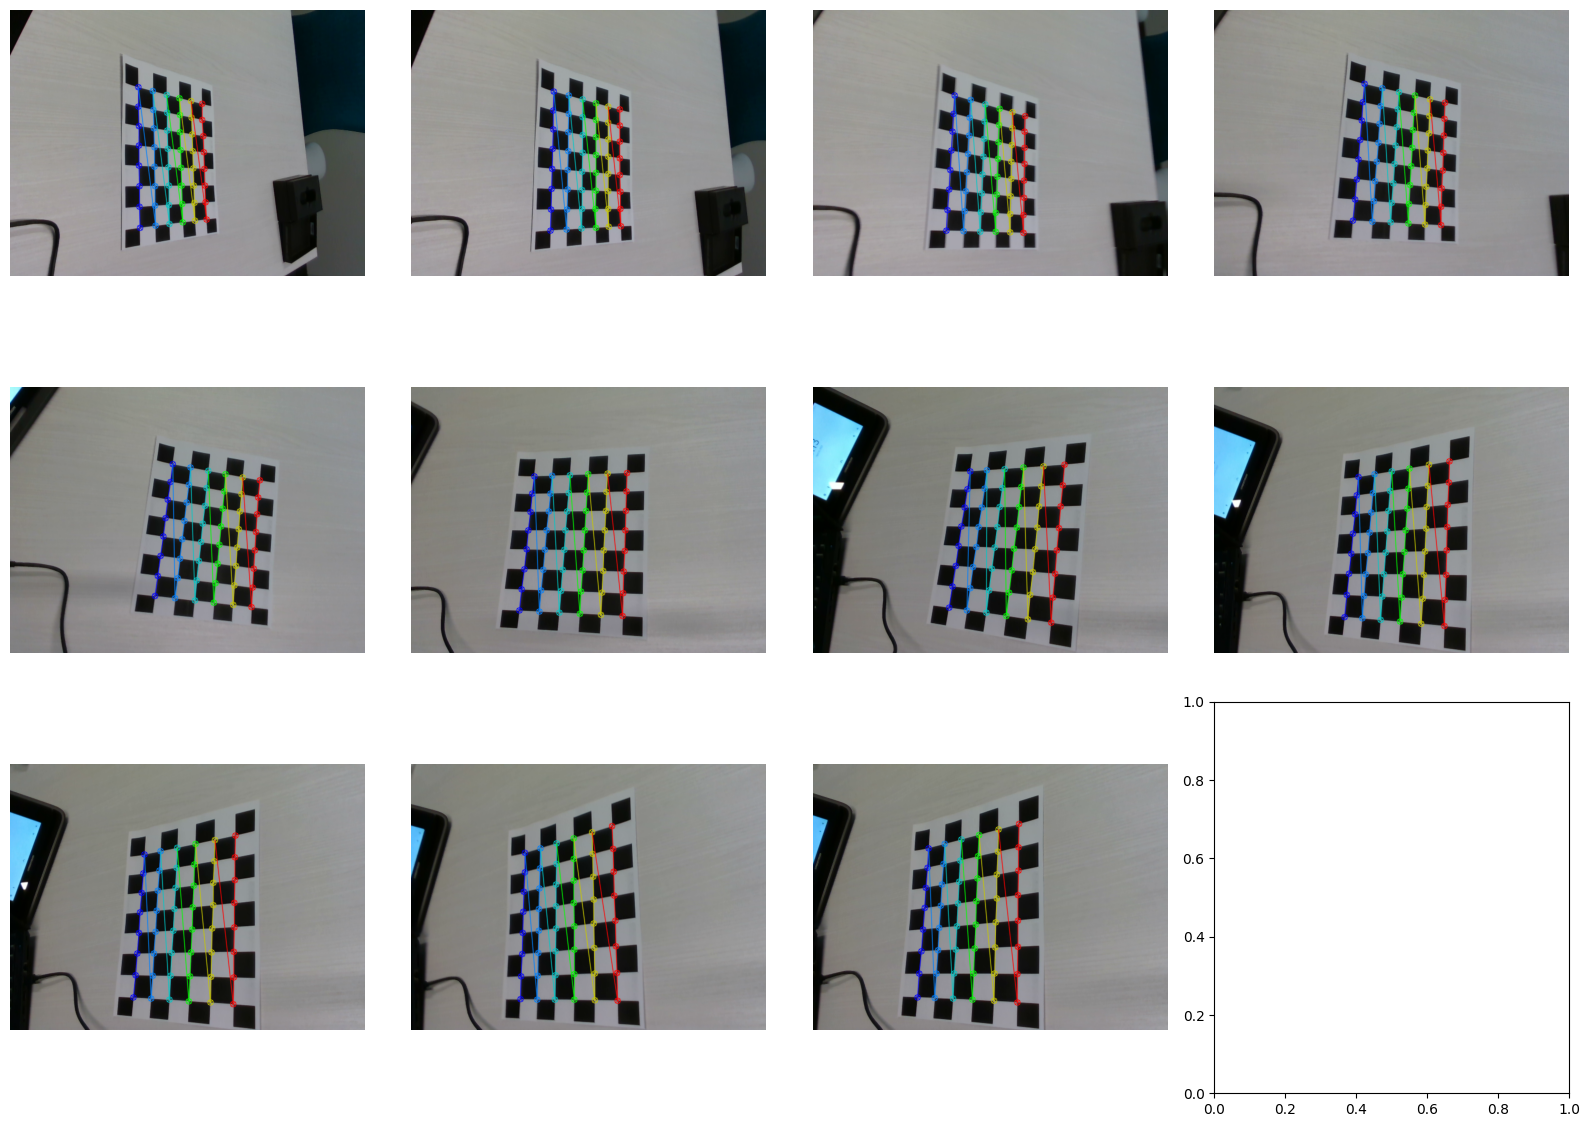

In [7]:
# Plot corners
f = lambda x: (x + 3) // 4
fig, axs = plt.subplots(f(n), 4, figsize=(16, 4*f(n)))
for i, ax in enumerate(axs.flatten()):
    try:
        img_tmp = color_imgs[i].copy()
        corners2 = imgpoints[i]
        img_tmp = cv2.drawChessboardCorners(img_tmp, cb_counts, corners2, True)
        ax.imshow(img_tmp)
        ax.axis("off")
    except:
        continue
plt.tight_layout()
plt.show()

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
h, w, _ = color_imgs[0].shape
mtx, dist

(array([[614.30370433,   0.        , 323.40618982],
        [  0.        , 613.49093489, 250.28650872],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 4.61491569e-03,  8.12618050e-01, -3.70082902e-03,
          5.19872901e-04, -3.35379655e+00]]))

In [9]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    corner = (int(corner[0]), int(corner[1]))
    imgpts = np.int32(imgpts).reshape(-1,2)

    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

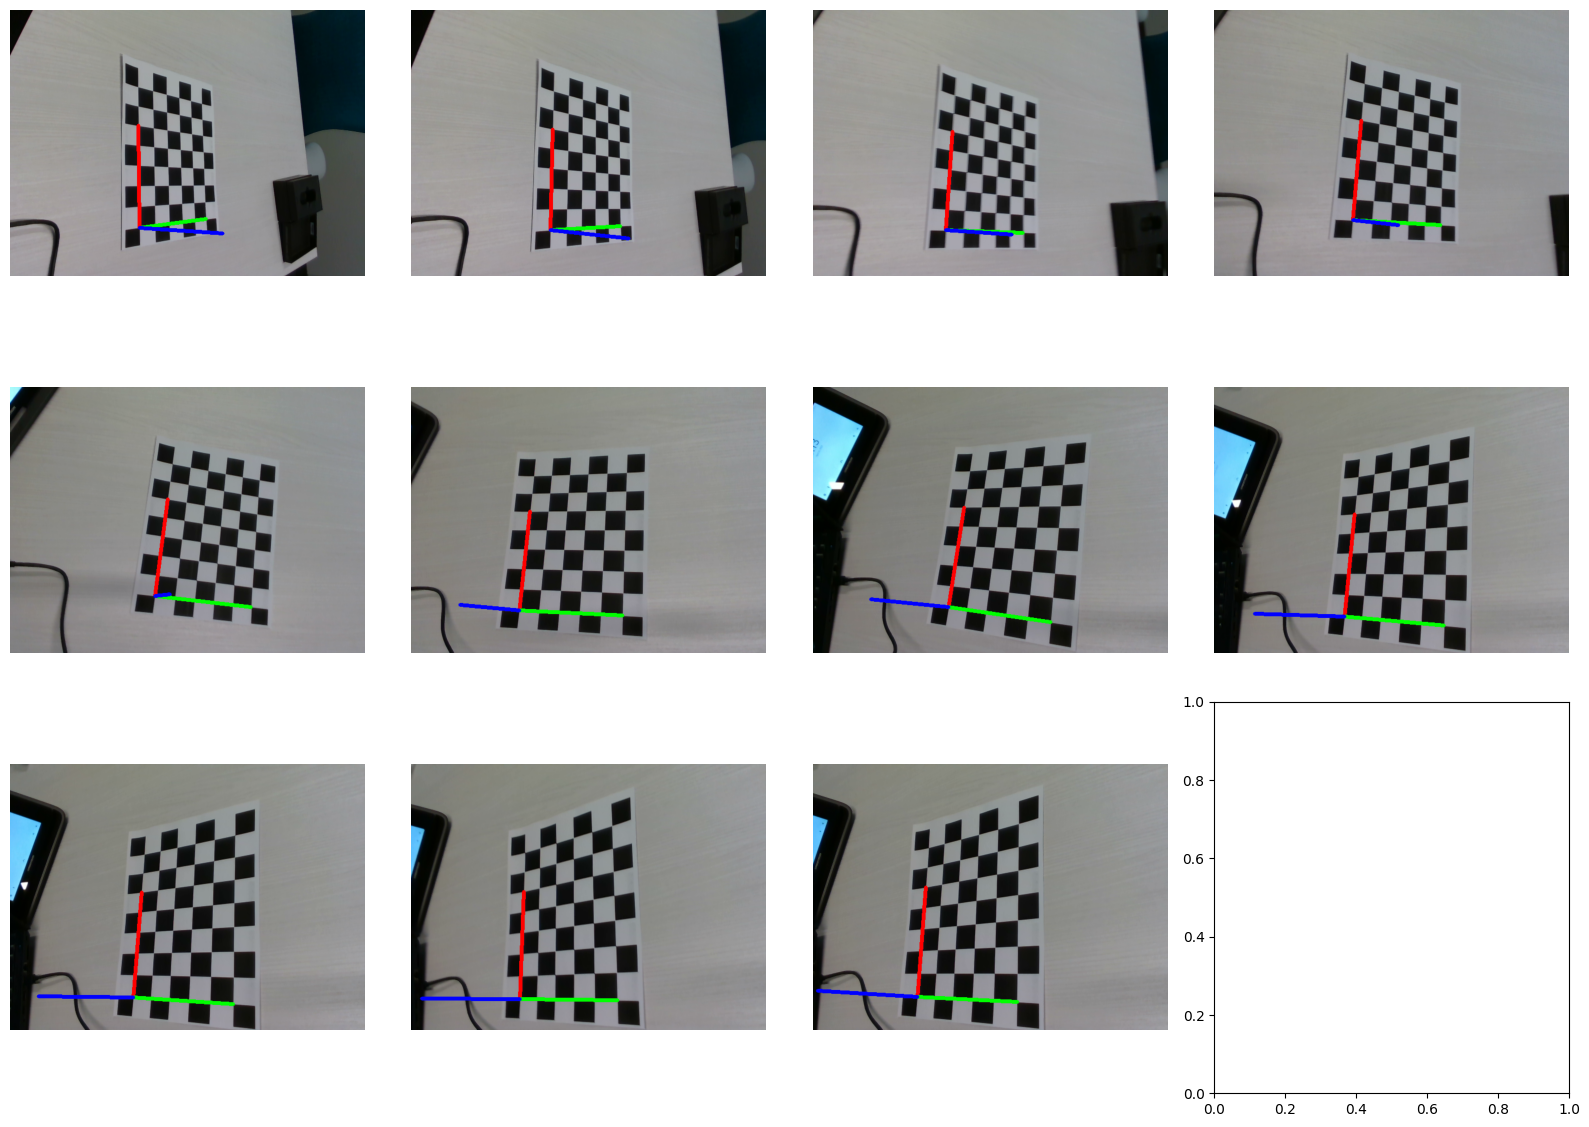

In [10]:
# Note the negative z axis
axis = np.float32([[1,0,0], [0,1,0], [0,0,-1]]).reshape(-1,3) * cb_size * 5

rvecs_lst = []
tvecs_lst = []
fig, axs = plt.subplots(f(n), 4, figsize=(16, 4*f(n)))
for i, ax in enumerate(axs.flatten()):
    try:
        img_tmp = color_imgs[i].copy()
        corners2 = imgpoints[i]

        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(
            objp, 
            corners2, 
            mtx, 
            dist,
            iterationsCount=1000,
            reprojectionError=0.5
        )

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img_tmp = draw(img_tmp, corners2, imgpts)
        ax.imshow(img_tmp)
        ax.axis("off")

        rvecs_lst.append(rvecs)
        tvecs_lst.append(tvecs)
    except:
        continue
plt.tight_layout()
plt.show()


In [11]:
# Turn lists into extrinsic parameters
rvecs = np.array(rvecs_lst)
tvecs = np.array(tvecs_lst)

# Turn into 4x4 extrinsic matrices
w2c_exts = np.zeros((len(rvecs), 4, 4))
c2w_exts = np.zeros((len(rvecs), 4, 4))
for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])
    w2c_exts[i, :3, :3] = R
    w2c_exts[i, :3, 3] = tvecs[i].T
    w2c_exts[i, 3, 3] = 1

    # world to camera -> camera to world
    c2w_exts[i] = np.linalg.inv(w2c_exts[i])

In [12]:
from utils import get_o3d_intrinsics, colordepth_to_rgbd, rgbd_to_pcd

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()
print(color_intrinsics.intrinsic_matrix)
print(mtx)

[[617.13928223   0.         318.18209839]
 [  0.         617.77008057 252.93757629]
 [  0.           0.           1.        ]]
[[614.30370433   0.         323.40618982]
 [  0.         613.49093489 250.28650872]
 [  0.           0.           1.        ]]


In [13]:
# i = 0
# rgbd_img = colordepth_to_rgbd(color_imgs[i], depth_imgs[i])
# w2c_ext = w2c_exts[i]
# c2w_ext = c2w_exts[i]

# voxel_size = 0.002
# pcd = rgbd_to_pcd(rgbd_img, color_intrinsics, voxel_size=voxel_size)
# # Scale the pointcloud
# # cb_scale = 0.03
# # pcd.scale(1/cb_scale, center=[0,0,0])

# origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3, origin=[0,0,0])

# # o3d.visualization.draw_geometries([pcd, origin], **vis_kwargs)

# size=0.5
# camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
# camera.transform(c2w_ext)

# pcd.transform(c2w_ext)

# o3d.visualization.draw_geometries([pcd, origin, camera])


In [25]:
cb_scale = 0.03
voxel_size = 0.002
camera_size = 2 * cb_scale
origin_size = 5 * cb_scale

In [26]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])

# Draw camera locations and rotations
cameras = []
pcds = []
intrinsics = color_intrinsics
for c2w_ext, color_img, depth_img in zip(c2w_exts, color_imgs, depth_imgs):
    # Get the RGBD image
    rgbd_img = colordepth_to_rgbd(color_img, depth_img)
    
    # Create a camera frame
    camera = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=camera_size, origin=[0,0,0])
    camera.transform(c2w_ext)

    # Create a pointcloud
    pcd = rgbd_to_pcd(rgbd_img, intrinsics, voxel_size=voxel_size)
    pcd.transform(c2w_ext)

    # Add to lists
    cameras.append(camera)
    pcds.append(pcd)


In [30]:
o3d.visualization.draw_geometries(pcds + [origin] + cameras)

[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

In [37]:
kwargs = {
    'zoom': 0.3,
    'front': [-1,-1,-1],
    'lookat': [0,0,0],
    'up': [0,0,-1]
}
o3d.visualization.draw_geometries(pcds + [origin] + cameras, **kwargs)